In [1]:
import numpy as np
import pandas as pd
from ase import Atoms
from ase import neighborlist
from ase import units
from ase.io.trajectory import Trajectory
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA as ARIMA_stats
from statsmodels.graphics.api import qqplot
from scipy import stats
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


# Load Data

In [2]:
force_df = pd.read_csv("Data/Moldyn_dataframe.csv")
atoms = ["C1", "C2", "O", "H1", "H2", "H3", "H4", "H5", "H6"]

# OLS

## AR

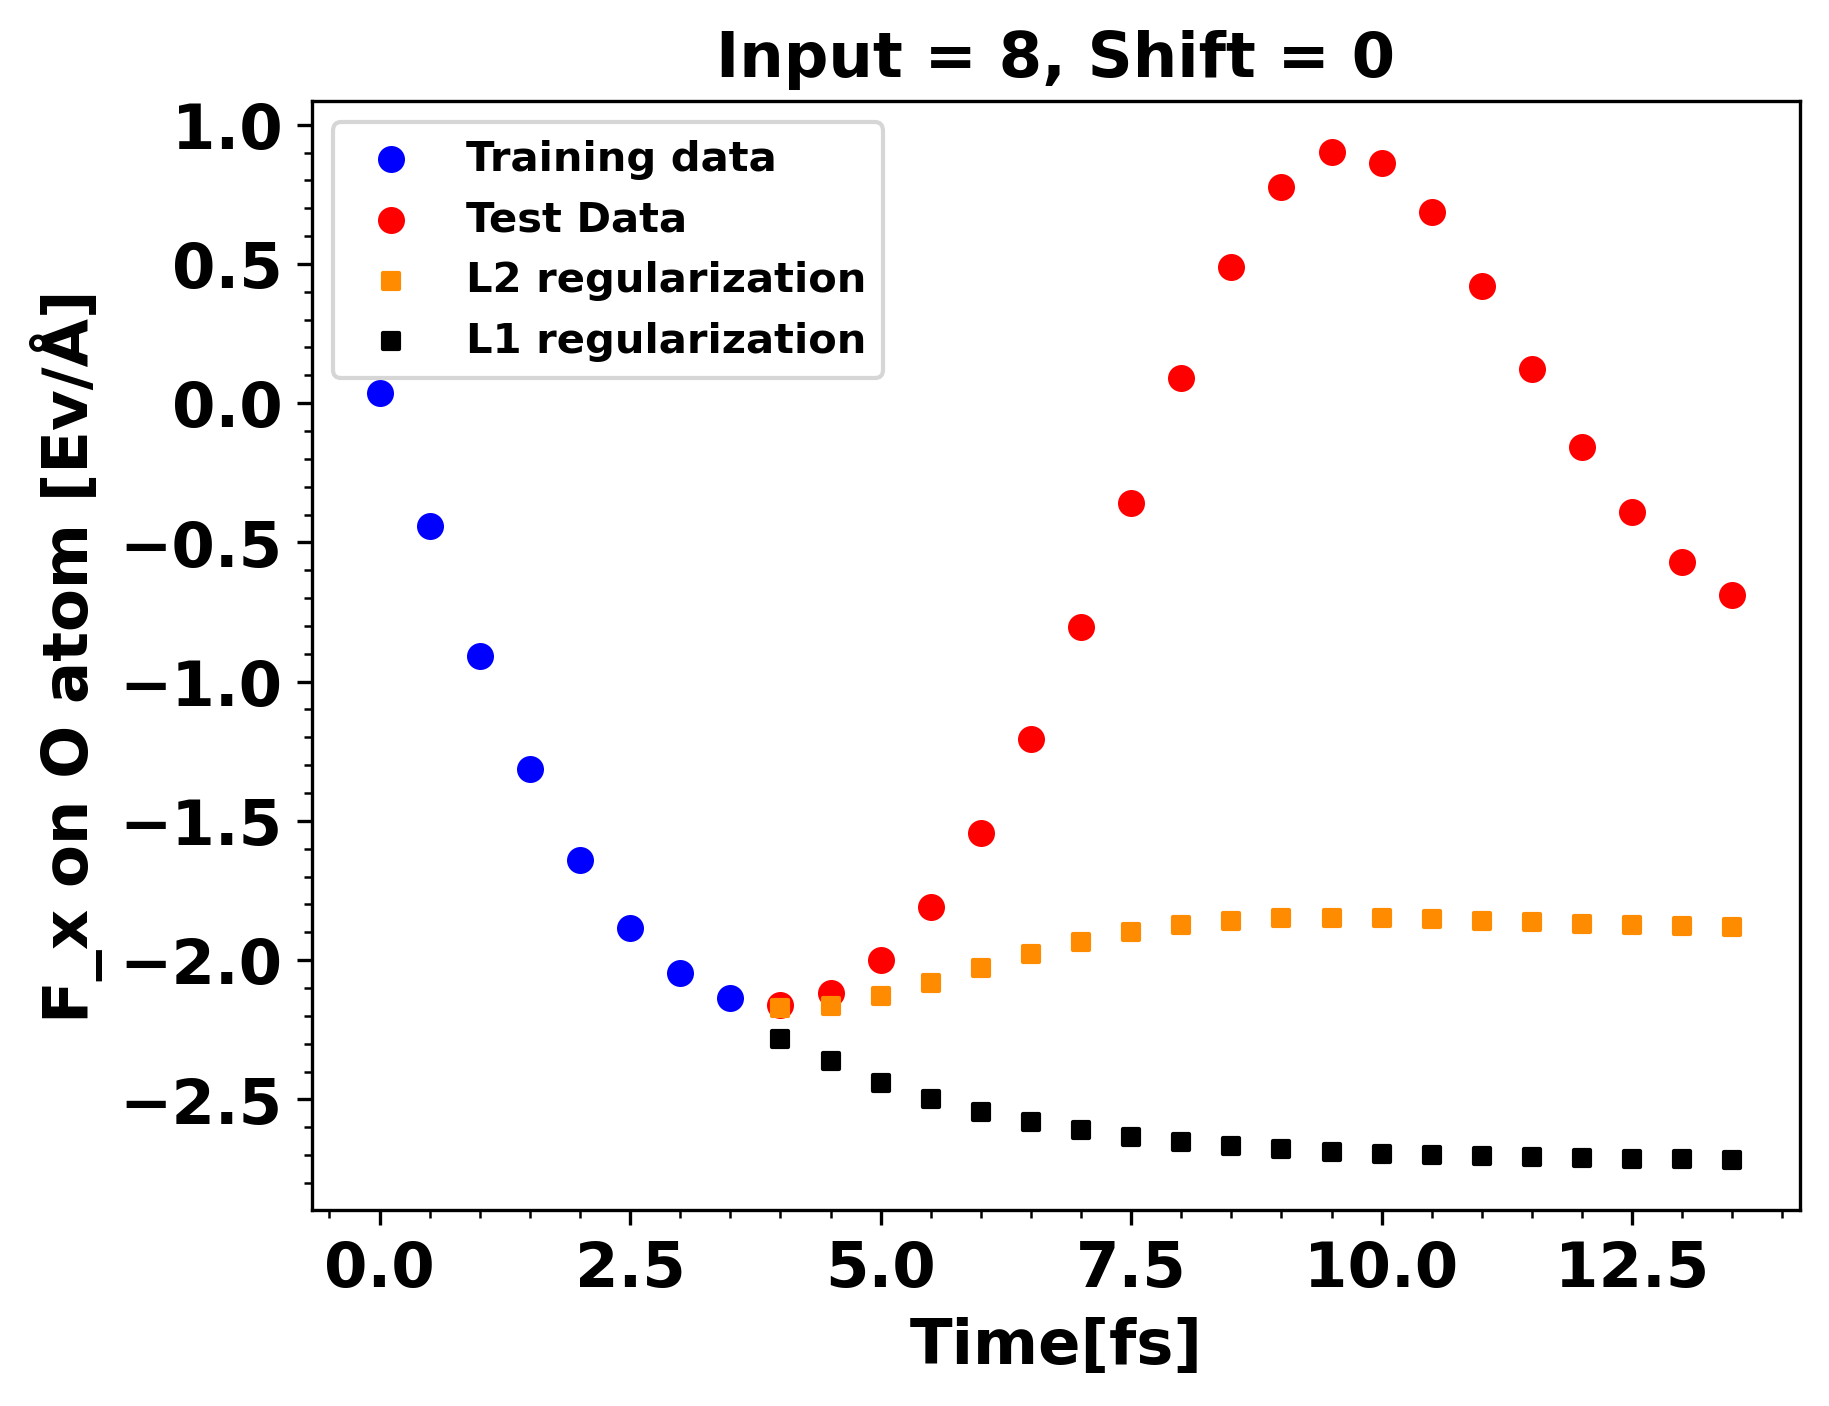

In [8]:
def create_OLS_model(time_series, order=2):
    input = len(time_series)-order
    X = np.zeros([input,order+1])
    for i in range(order):
        #print(time_series.shift(i+1)[i+1:len(time_series)-order+i+1])
        X[:,i] = time_series[i:input+i]
    X[:,-1] = np.ones(len(time_series)-order)
    return sm.OLS(time_series[order:], X)

input = 8
shift = 0
pred_step = 20


columns = force_df.drop('Unnamed: 0', axis=1).columns.values.tolist()

model_ridge = create_OLS_model(force_df['O(x)'][shift:shift+input])
arma_mod_ridge = model_ridge.fit_regularized(method="elastic_net", L1_wt=0)

pred_ridge = np.zeros(pred_step+2)
pred_ridge[:2] = force_df['O(x)'][shift+input-2:shift+input]

for i in range(pred_step):
    X = np.array([pred_ridge[i], pred_ridge[i+1],  1])
    pred_ridge[i+2] = arma_mod_ridge.predict(X)

model_lasso = create_OLS_model(force_df['O(x)'][shift:shift+input])
arma_mod_lasso = model_lasso.fit_regularized(method="elastic_net", L1_wt=1)

pred_lasso = np.zeros(pred_step+2)
pred_lasso[:2] = force_df['O(x)'][shift+input-2:shift+input]

for i in range(pred_step):
    X = np.array([pred_lasso[i], pred_lasso[i+1],  1])
    pred_lasso[i+2] = arma_mod_lasso.predict(X)



force_O = np.array([force_df['O(x)'], force_df['O(y)'], force_df['O(z)']])
plt.scatter(force_df['Unnamed: 0'][shift:input+shift]*0.5, force_df['O(x)'][shift:input+shift], color="Blue", label="Training data", s=30)
plt.scatter(force_df['Unnamed: 0'][shift+input:input+shift+pred_step]*0.5, force_df['O(x)'][shift+input:input+shift+pred_step], color="Red", label="Test Data", s=30)
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, pred_ridge[2:], label="L2 regularization", s=15, marker="s", color="darkorange")
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, pred_lasso[2:], label="L1 regularization", s=15, marker="s", color="Black")
plt.title("Input = "+str(input)+", Shift = "+str(shift), fontweight="bold")
plt.xlabel("Time[fs]", fontweight="bold")
plt.ylabel("F_x on O atom [Ev/Å]", fontweight="bold")
plt.legend()
plt.show()

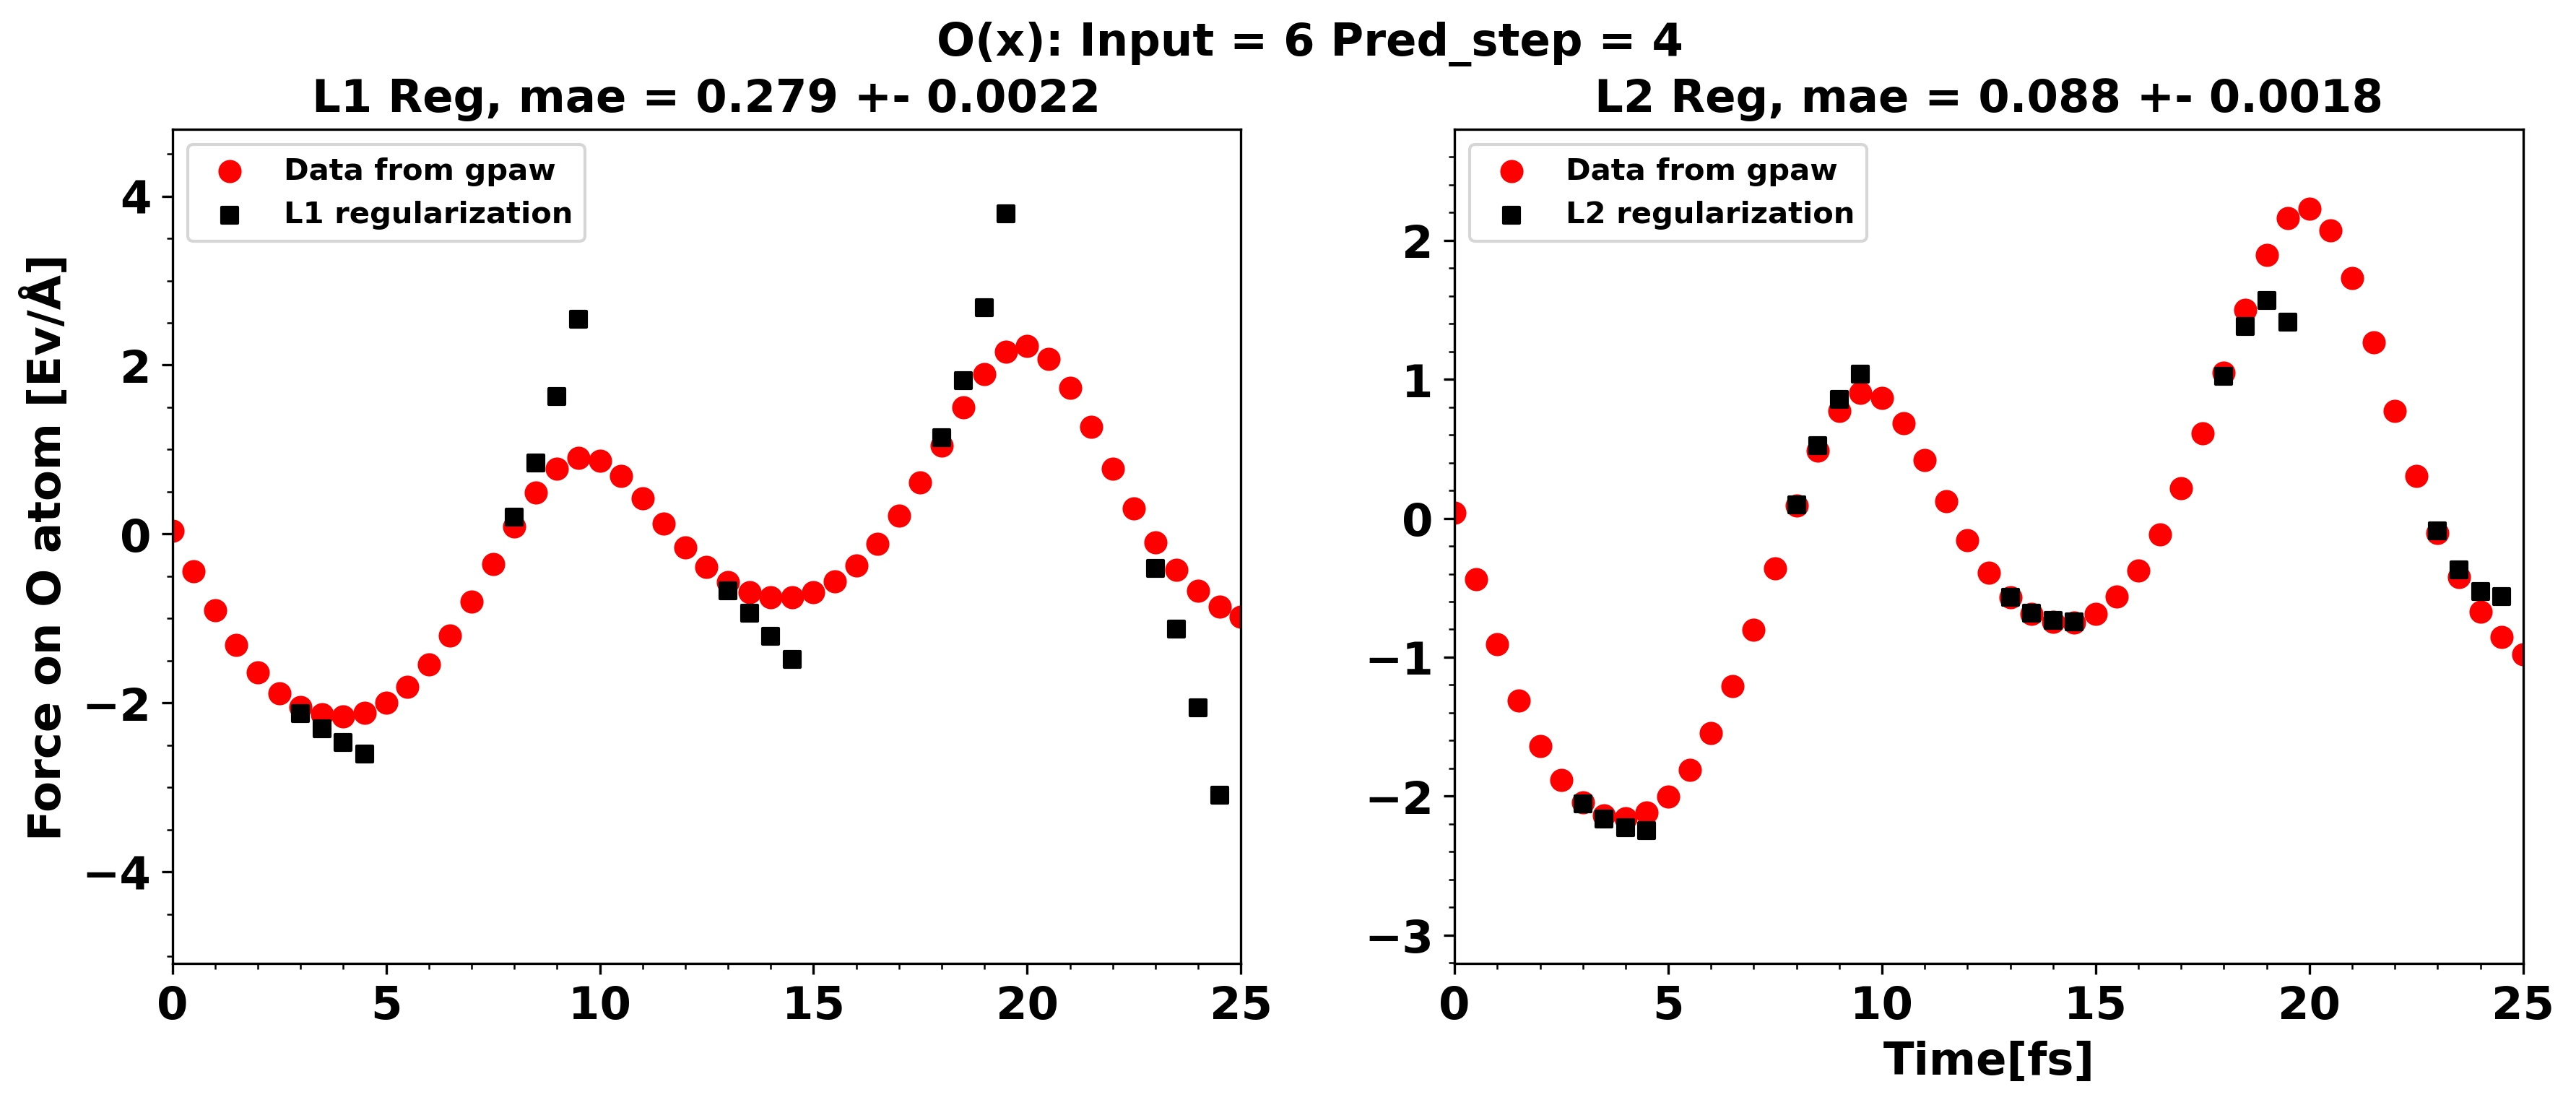

In [10]:
input = 6
pred_step = 4

time = []
n = 0
i = 0
columns = force_df.drop('Unnamed: 0', axis=1).columns.values.tolist()
pred_ridge = np.zeros([300])
pred_lasso = np.zeros([300])

while i<(len(force_df['O(y)'])-1):
    arma_mod_ridge = create_OLS_model(force_df['O(x)'][i:i+input]).fit_regularized(L1_wt=0)
    arma_mod_lasso = create_OLS_model(force_df['O(x)'][i:i+input]).fit_regularized(L1_wt=1)
    forecast_ridge = np.zeros(pred_step+2)
    forecast_lasso = np.zeros(pred_step+2)
    forecast_ridge[:2] = force_df['O(x)'][i+input-2:i+input]
    forecast_lasso[:2] = force_df['O(x)'][i+input-2:i+input]

    for j in range(pred_step):
        X_ridge = np.array([forecast_ridge[j], forecast_ridge[j+1],  1])
        X_lasso = np.array([forecast_lasso[j], forecast_lasso[j+1],  1])
        forecast_ridge[j+2] = arma_mod_ridge.predict(X_ridge)
        forecast_lasso[j+2] = arma_mod_lasso.predict(X_lasso)
        time.append((i+input+j))

    pred_ridge[n:n+pred_step] = forecast_ridge[2:]
    pred_lasso[n:n+pred_step] = forecast_lasso[2:]
    n += pred_step
    i+=pred_step+input

time = np.asarray(time).astype('int32')
index = time
data = np.asarray(force_df['O(x)'])
mae_ridge = np.sum(np.abs(pred_ridge[:len(time)]-data[index])/(pred_ridge.shape[0]))
mae_lasso = np.sum(np.abs(pred_lasso[:len(time)]-data[index])/(pred_lasso.shape[0]))

std_ridge = np.std(np.abs(pred_ridge[:len(time)]-data[index])/(pred_ridge.shape[0]))
std_lasso = np.std(np.abs(pred_lasso[:len(time)]-data[index])/(pred_lasso.shape[0]))
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
force_O = np.array([force_df['O(x)'], force_df['O(y)'], force_df['O(z)']])

ax[0].scatter(force_df['Unnamed: 0']*0.5, force_O[0,:], color="red", label="Data from gpaw", s=45)
ax[0].scatter(time*0.5, pred_lasso[:len(time)], label="L1 regularization", s=30, marker="s", color="Black")
ax[0].legend()
ax[1].scatter(force_df['Unnamed: 0']*0.5, force_O[0,:], color="red", label="Data from gpaw", s=45)
ax[1].scatter(time*0.5, pred_ridge[:len(time)], label="L2 regularization", s=30, marker="s", color="Black")
ax[1].legend()
ax[0].set_title("L1 Reg, mae = "+str(np.round(mae_lasso, 3))+" +- "+str(np.round(std_lasso, 4)), fontweight="bold")
ax[1].set_title("L2 Reg, mae = "+str(np.round(mae_ridge, 3))+" +- "+str(np.round(std_ridge, 4)), fontweight="bold")
ax[1].set_xlabel("Time[fs]", fontweight="bold")
ax[0].set_ylabel("Force on O atom [Ev/Å]", fontweight="bold")  
ax[0].set_xlim(0, 25)
ax[1].set_xlim(0, 25)
plt.suptitle("O(x): Input = "+str(input)+" Pred_step = "+str(pred_step), fontweight="bold", fontsize=15)
OLS_AR = pred_ridge[:len(time)]
plt.show()

## VAR

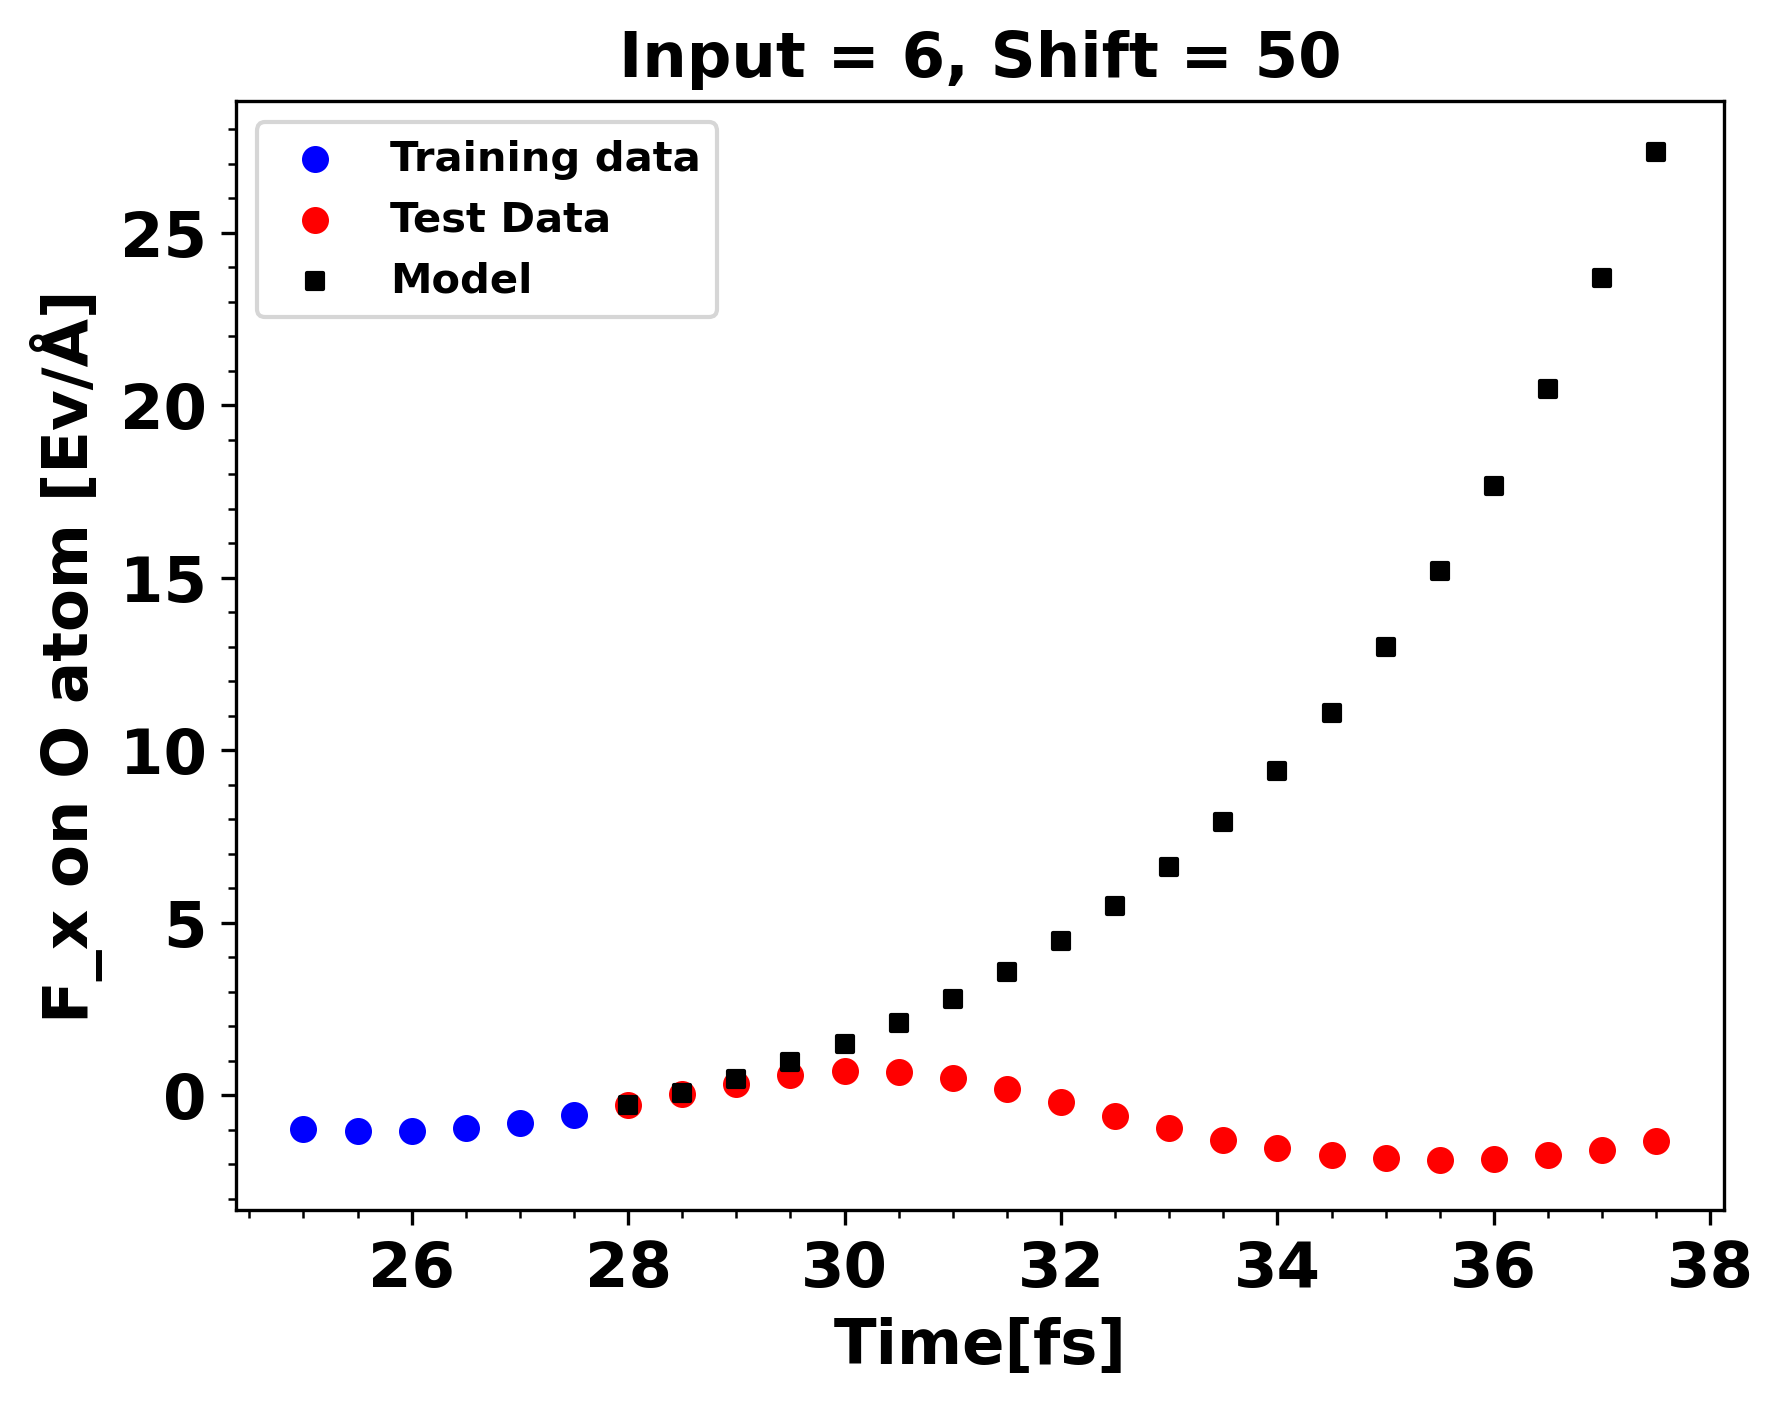

In [28]:
def create_VAR_OLS_model(main, secondary, order=2):
    input = len(main)-order
    num_secondaries = secondary.shape[0]
    X = np.zeros([input,order*(num_secondaries+1)+1])
    for i in range(order):
        X[:,i*(num_secondaries+1)] = main[i:input+i]
        for j in range(num_secondaries):
            X[:,i*(num_secondaries+1)+j+1] = secondary[j,i:input+i]
    X[:,-1] = np.ones(len(main)-order)
    return sm.OLS(main[order:], X)
input = 6
pred_step = 20
shift = 50
arma_mod_x = create_VAR_OLS_model(force_df['O(x)'][shift:input+shift], np.array([force_df['O(y)'][shift:input+shift], force_df['O(z)'][shift:input+shift]])).fit_regularized(L1_wt=0)
arma_mod_y = create_VAR_OLS_model(force_df['O(y)'][shift:input+shift], np.array([force_df['O(x)'][shift:input+shift], force_df['O(z)'][shift:input+shift]])).fit_regularized(L1_wt=0)
arma_mod_z = create_VAR_OLS_model(force_df['O(z)'][shift:input+shift], np.array([force_df['O(x)'][shift:input+shift], force_df['O(y)'][shift:input+shift]])).fit_regularized(L1_wt=0)
forecast_x = np.zeros(pred_step+2)
forecast_y = np.zeros(pred_step+2)
forecast_z = np.zeros(pred_step+2)
forecast_x[:2] = force_df['O(x)'][shift+input-2:input+shift]
forecast_y[:2] = force_df['O(y)'][shift+input-2:input+shift]
forecast_z[:2] = force_df['O(z)'][shift+input-2:input+shift]
for j in range(pred_step):
    X_x = np.array([forecast_x[j], forecast_y[j], forecast_z[j], forecast_x[j+1], forecast_y[j+1], forecast_z[j+1],  1])
    X_y = np.array([forecast_y[j], forecast_x[j], forecast_z[j], forecast_y[j+1], forecast_x[j+1], forecast_z[j+1],  1])
    X_z = np.array([forecast_z[j], forecast_x[j], forecast_y[j], forecast_z[j+1], forecast_x[j+1], forecast_y[j+1],  1])
    forecast_x[j+2] = arma_mod_x.predict(X_x)
    forecast_y[j+2] = arma_mod_y.predict(X_y)
    forecast_z[j+2] = arma_mod_z.predict(X_z)

plt.scatter(force_df['Unnamed: 0'][shift:input+shift]*0.5, force_df['O(x)'][shift:input+shift], color="Blue", label="Training data", s=30)
plt.scatter(force_df['Unnamed: 0'][shift+input:input+shift+pred_step]*0.5, force_df['O(x)'][shift+input:input+shift+pred_step], color="Red", label="Test Data", s=30)
plt.scatter(np.arange(input+shift, input+shift+pred_step)*0.5, forecast_x[2:], label="Model", s=15, marker="s", color="Black")
plt.title("Input = "+str(input)+", Shift = "+str(shift), fontweight="bold")
plt.xlabel("Time[fs]", fontweight="bold")
plt.ylabel("F_x on O atom [Ev/Å]", fontweight="bold")
plt.legend()
plt.show()



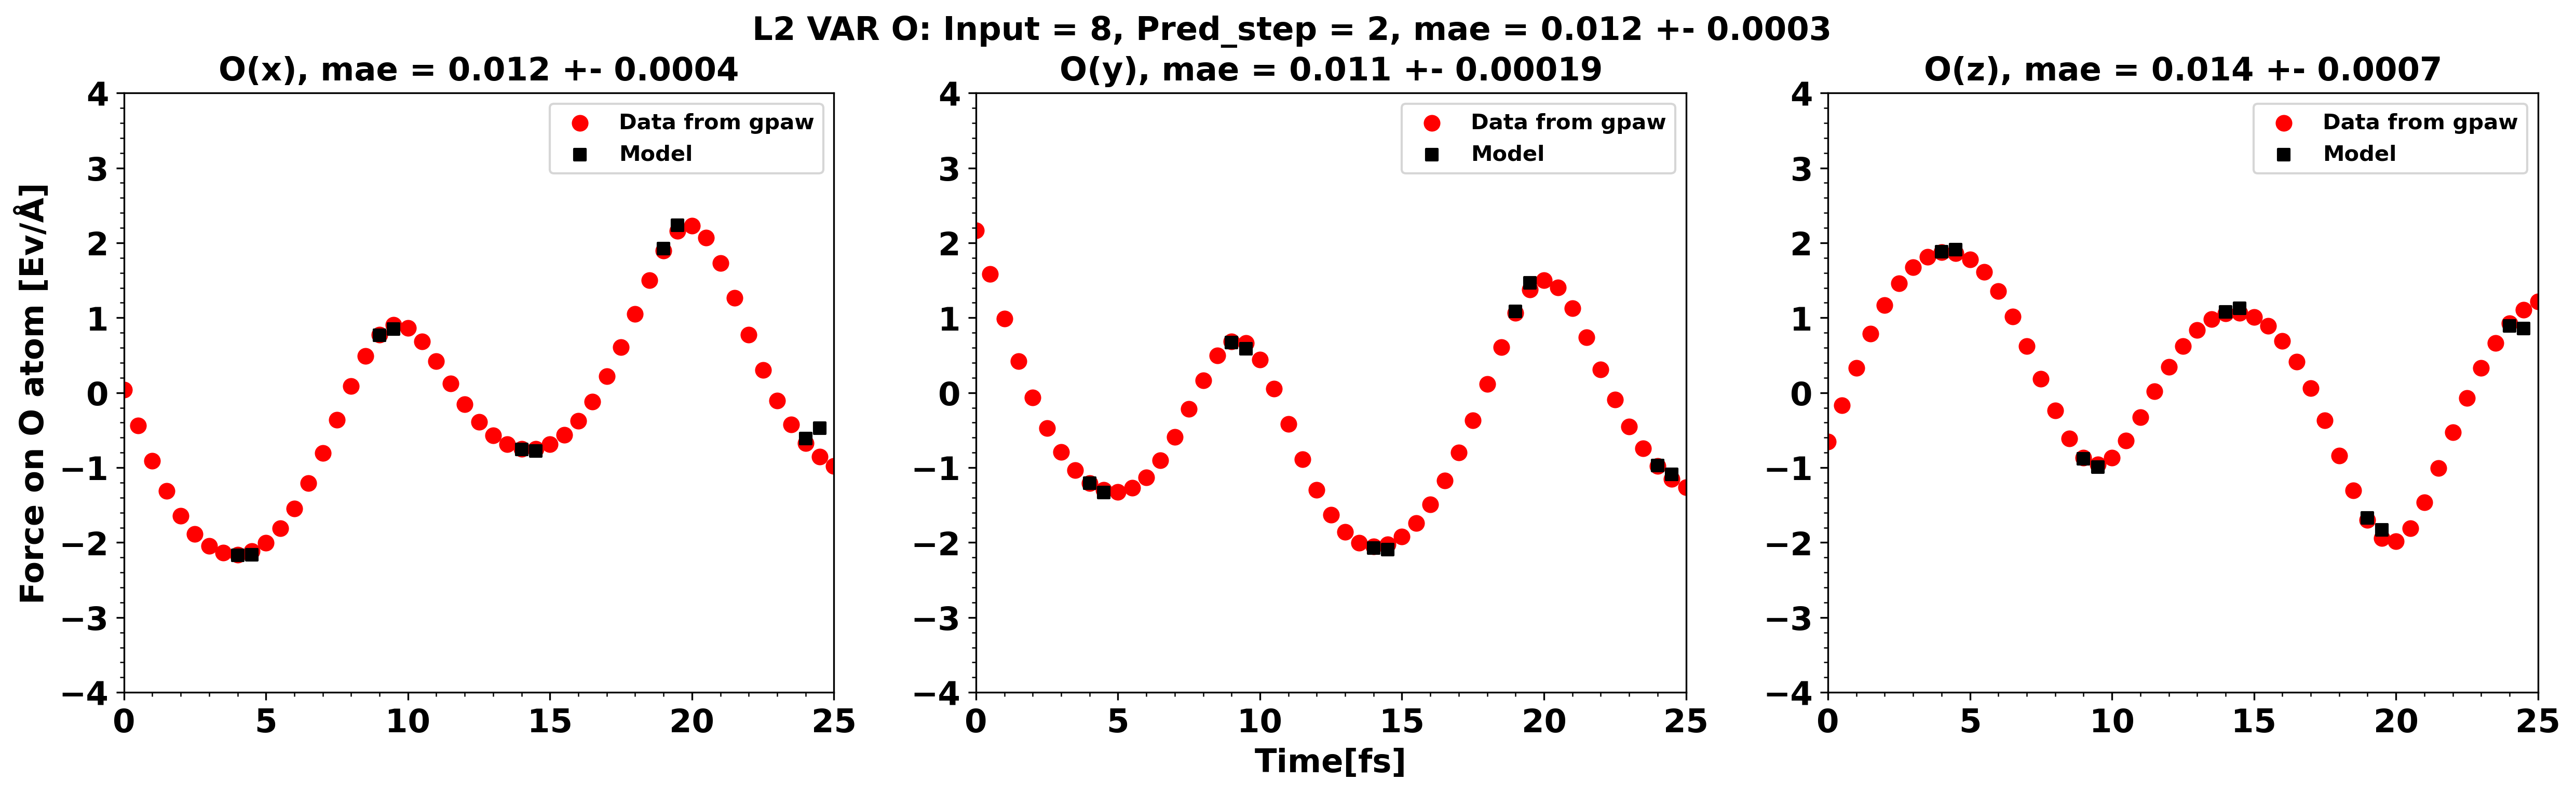

In [3]:

def create_VAR_OLS_model(main, secondary, order=2):
    input = len(main)-order
    num_secondaries = secondary.shape[0]
    X = np.zeros([input,order*(num_secondaries+1)+1])
    for i in range(order):
        X[:,i*(num_secondaries+1)] = main[i:input+i]
        for j in range(num_secondaries):
            X[:,i*(num_secondaries+1)+j+1] = secondary[j,i:input+i]
    X[:,-1] = np.ones(len(main)-order)
    return sm.OLS(main[order:], X)

input = 8
pred_step = 2

time = []
n = 0
i = 0
columns = force_df.drop('Unnamed: 0', axis=1).columns.values.tolist()
pred_x = np.zeros([300])
pred_y = np.zeros([300])
pred_z = np.zeros([300])

while i<(len(force_df['O(y)'])-1):
    arma_mod_x = create_VAR_OLS_model(force_df['O(x)'][i:i+input], np.array([force_df['O(y)'][i:i+input], force_df['O(z)'][i:i+input]])).fit_regularized(L1_wt=0)
    arma_mod_y = create_VAR_OLS_model(force_df['O(y)'][i:i+input], np.array([force_df['O(x)'][i:i+input], force_df['O(z)'][i:i+input]])).fit_regularized(L1_wt=0)
    arma_mod_z = create_VAR_OLS_model(force_df['O(z)'][i:i+input], np.array([force_df['O(x)'][i:i+input], force_df['O(y)'][i:i+input]])).fit_regularized(L1_wt=0)
    forecast_x = np.zeros(pred_step+2)
    forecast_y = np.zeros(pred_step+2)
    forecast_z = np.zeros(pred_step+2)
    forecast_x[:2] = force_df['O(x)'][i+input-2:i+input]
    forecast_y[:2] = force_df['O(y)'][i+input-2:i+input]
    forecast_z[:2] = force_df['O(z)'][i+input-2:i+input]
    
    for j in range(pred_step):
        X_x = np.array([forecast_x[j], forecast_y[j], forecast_z[j], forecast_x[j+1], forecast_y[j+1], forecast_z[j+1],  1])
        X_y = np.array([forecast_y[j], forecast_x[j], forecast_z[j], forecast_y[j+1], forecast_x[j+1], forecast_z[j+1],  1])
        X_z = np.array([forecast_z[j], forecast_x[j], forecast_y[j], forecast_z[j+1], forecast_x[j+1], forecast_y[j+1],  1])
        forecast_x[j+2] = arma_mod_x.predict(X_x)
        forecast_y[j+2] = arma_mod_y.predict(X_y)
        forecast_z[j+2] = arma_mod_z.predict(X_z)

        time.append((i+input+j))

    pred_x[n:n+pred_step] = forecast_x[2:]
    pred_y[n:n+pred_step] = forecast_y[2:]
    pred_z[n:n+pred_step] = forecast_z[2:]
    n += pred_step
    i+=pred_step+input

time = np.asarray(time).astype('int32')
index = time
data_x = np.asarray(force_df['O(x)'])
data_y = np.asarray(force_df['O(y)'])
data_z = np.asarray(force_df['O(z)'])
mae_x = np.sum(np.abs(pred_x[:len(time)]-data_x[index])/(pred_x.shape[0]))
mae_y = np.sum(np.abs(pred_y[:len(time)]-data_y[index])/(pred_y.shape[0]))
mae_z = np.sum(np.abs(pred_z[:len(time)]-data_z[index])/(pred_z.shape[0]))
mae_total = (np.sum(np.abs(pred_x[:len(time)]-data_x[index]))+np.sum(np.abs(pred_y[:len(time)]-data_y[index]))+np.sum(np.abs(pred_z[:len(time)]-data_z[index])))/(3*pred_z.shape[0])
std_x = np.std(np.abs(pred_x[:len(time)]-data_x[index])/(pred_x.shape[0]))
std_y = np.std(np.abs(pred_y[:len(time)]-data_y[index])/(pred_y.shape[0]))
std_z = np.std(np.abs(pred_z[:len(time)]-data_z[index])/(pred_z.shape[0]))
std_total = np.sqrt((std_x/3)**2+(std_y/3)**2+(std_z/3)**2)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
force_O = np.array([force_df['O(x)'], force_df['O(y)'], force_df['O(z)']])

ax[0].scatter(force_df['Unnamed: 0']*0.5, force_O[0,:], color="red", label="Data from gpaw", s=45)
ax[0].scatter(time*0.5, pred_x[:len(time)], label="Model", s=30, marker="s", color="Black")
ax[0].legend()
ax[1].scatter(force_df['Unnamed: 0']*0.5, force_O[1,:], color="red", label="Data from gpaw", s=45)
ax[1].scatter(time*0.5, pred_y[:len(time)], label="Model", s=30, marker="s", color="Black")
ax[1].legend()
ax[2].scatter(force_df['Unnamed: 0']*0.5, force_O[2,:], color="red", label="Data from gpaw", s=45)
ax[2].scatter(time*0.5, pred_z[:len(time)], label="Model", s=30, marker="s", color="Black")
ax[2].legend()
ax[0].set_title("O(x), mae = "+str(np.round(mae_x, 3))+" +- "+str(np.round(std_x, 4)), fontweight="bold")
ax[1].set_title("O(y), mae = "+str(np.round(mae_y, 3))+" +- "+str(np.round(std_y, 5)), fontweight="bold")
ax[2].set_title("O(z), mae = "+str(np.round(mae_z, 3))+" +- "+str(np.round(std_z, 4)), fontweight="bold")
ax[1].set_xlabel("Time[fs]", fontweight="bold")
ax[0].set_ylabel("Force on O atom [Ev/Å]", fontweight="bold")  
ax[0].set_ylim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[2].set_ylim(-4, 4)
ax[0].set_xlim(0, 25)
ax[1].set_xlim(0, 25)
ax[2].set_xlim(0, 25)
plt.suptitle("L2 VAR O: Input = "+str(input)+", Pred_step = "+str(pred_step)+", mae = "+str(np.round(mae_total, 3))+" +- "+str(np.round(std_total, 4)), fontweight="bold", fontsize=15)
OLS_VAR = pred_x[:len(time)]
plt.show()

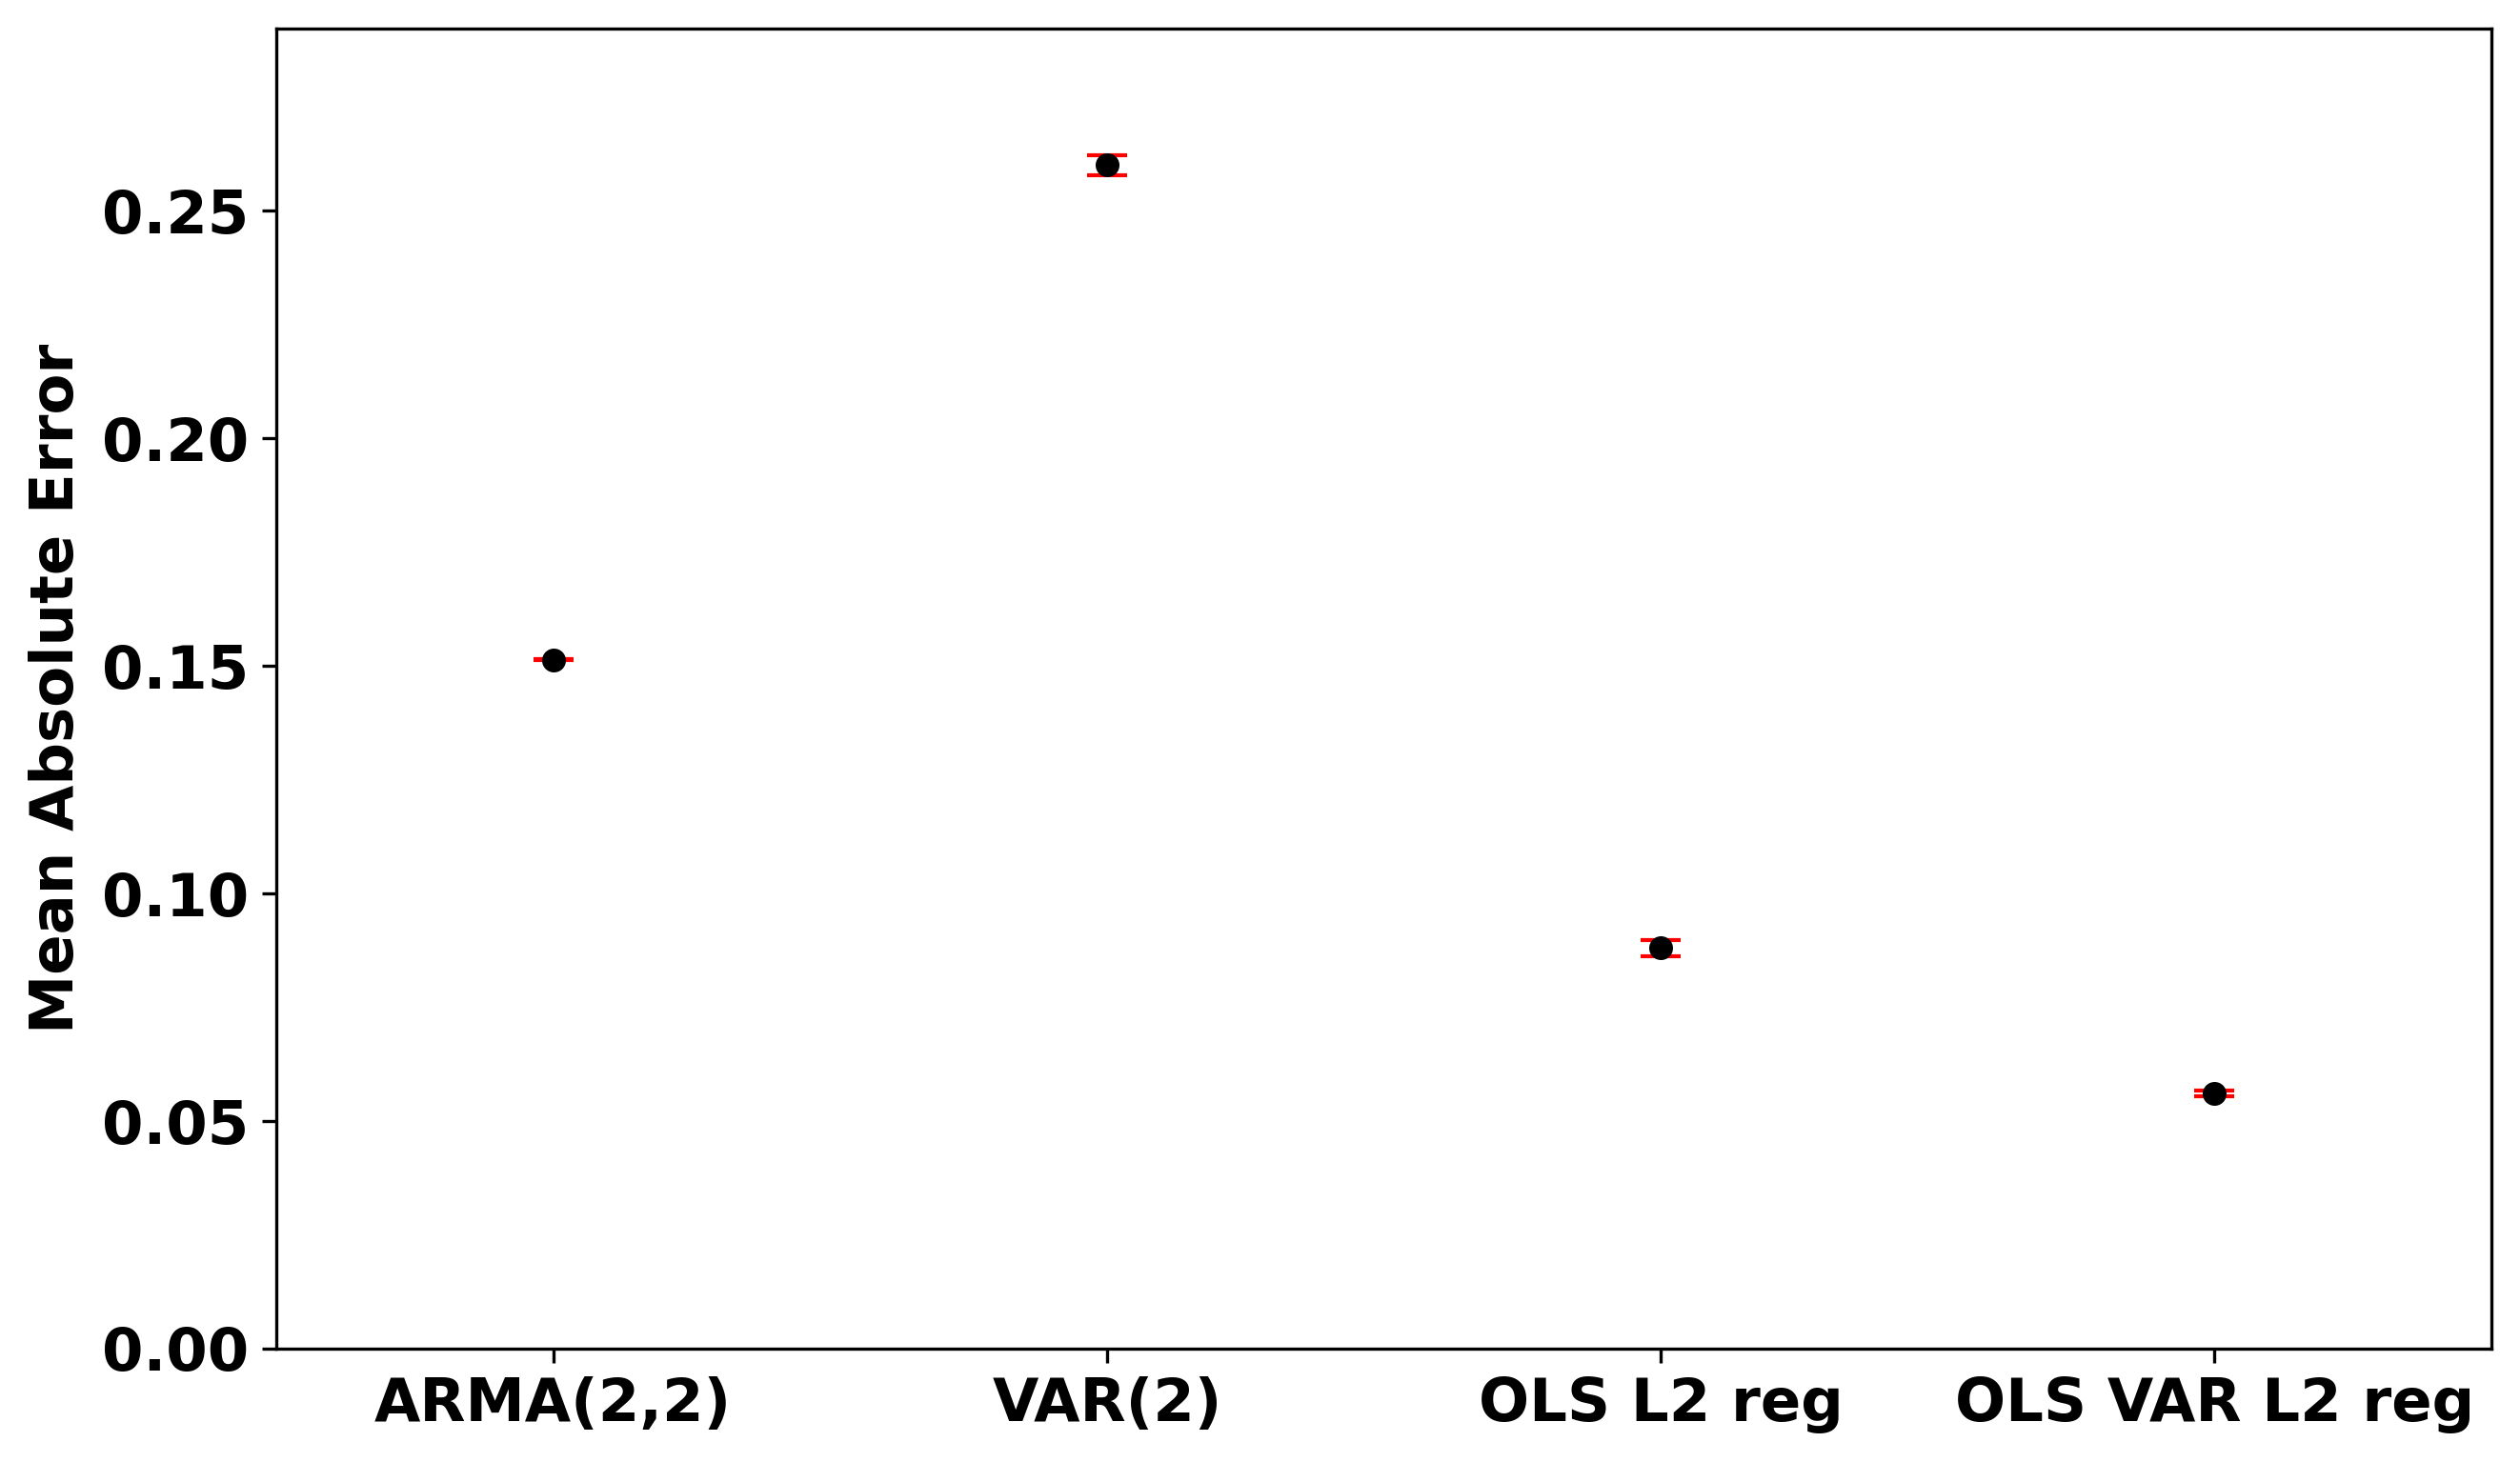

In [16]:
mae = [0.151287, 0.26,  0.088, 0.056]
std = [6.7e-5, 0.0022,  0.0018, 0.0006]
label = ['ARMA(2,2)','VAR(2)',  'OLS L2 reg', 'OLS VAR L2 reg']

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(range(1, 5), mae, yerr=np.array(std), fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
ax.set_xticks(range(1, 5), label)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 0.29)
ax.set_ylabel("Mean Absolute Error", fontweight="bold")
ax.minorticks_off()

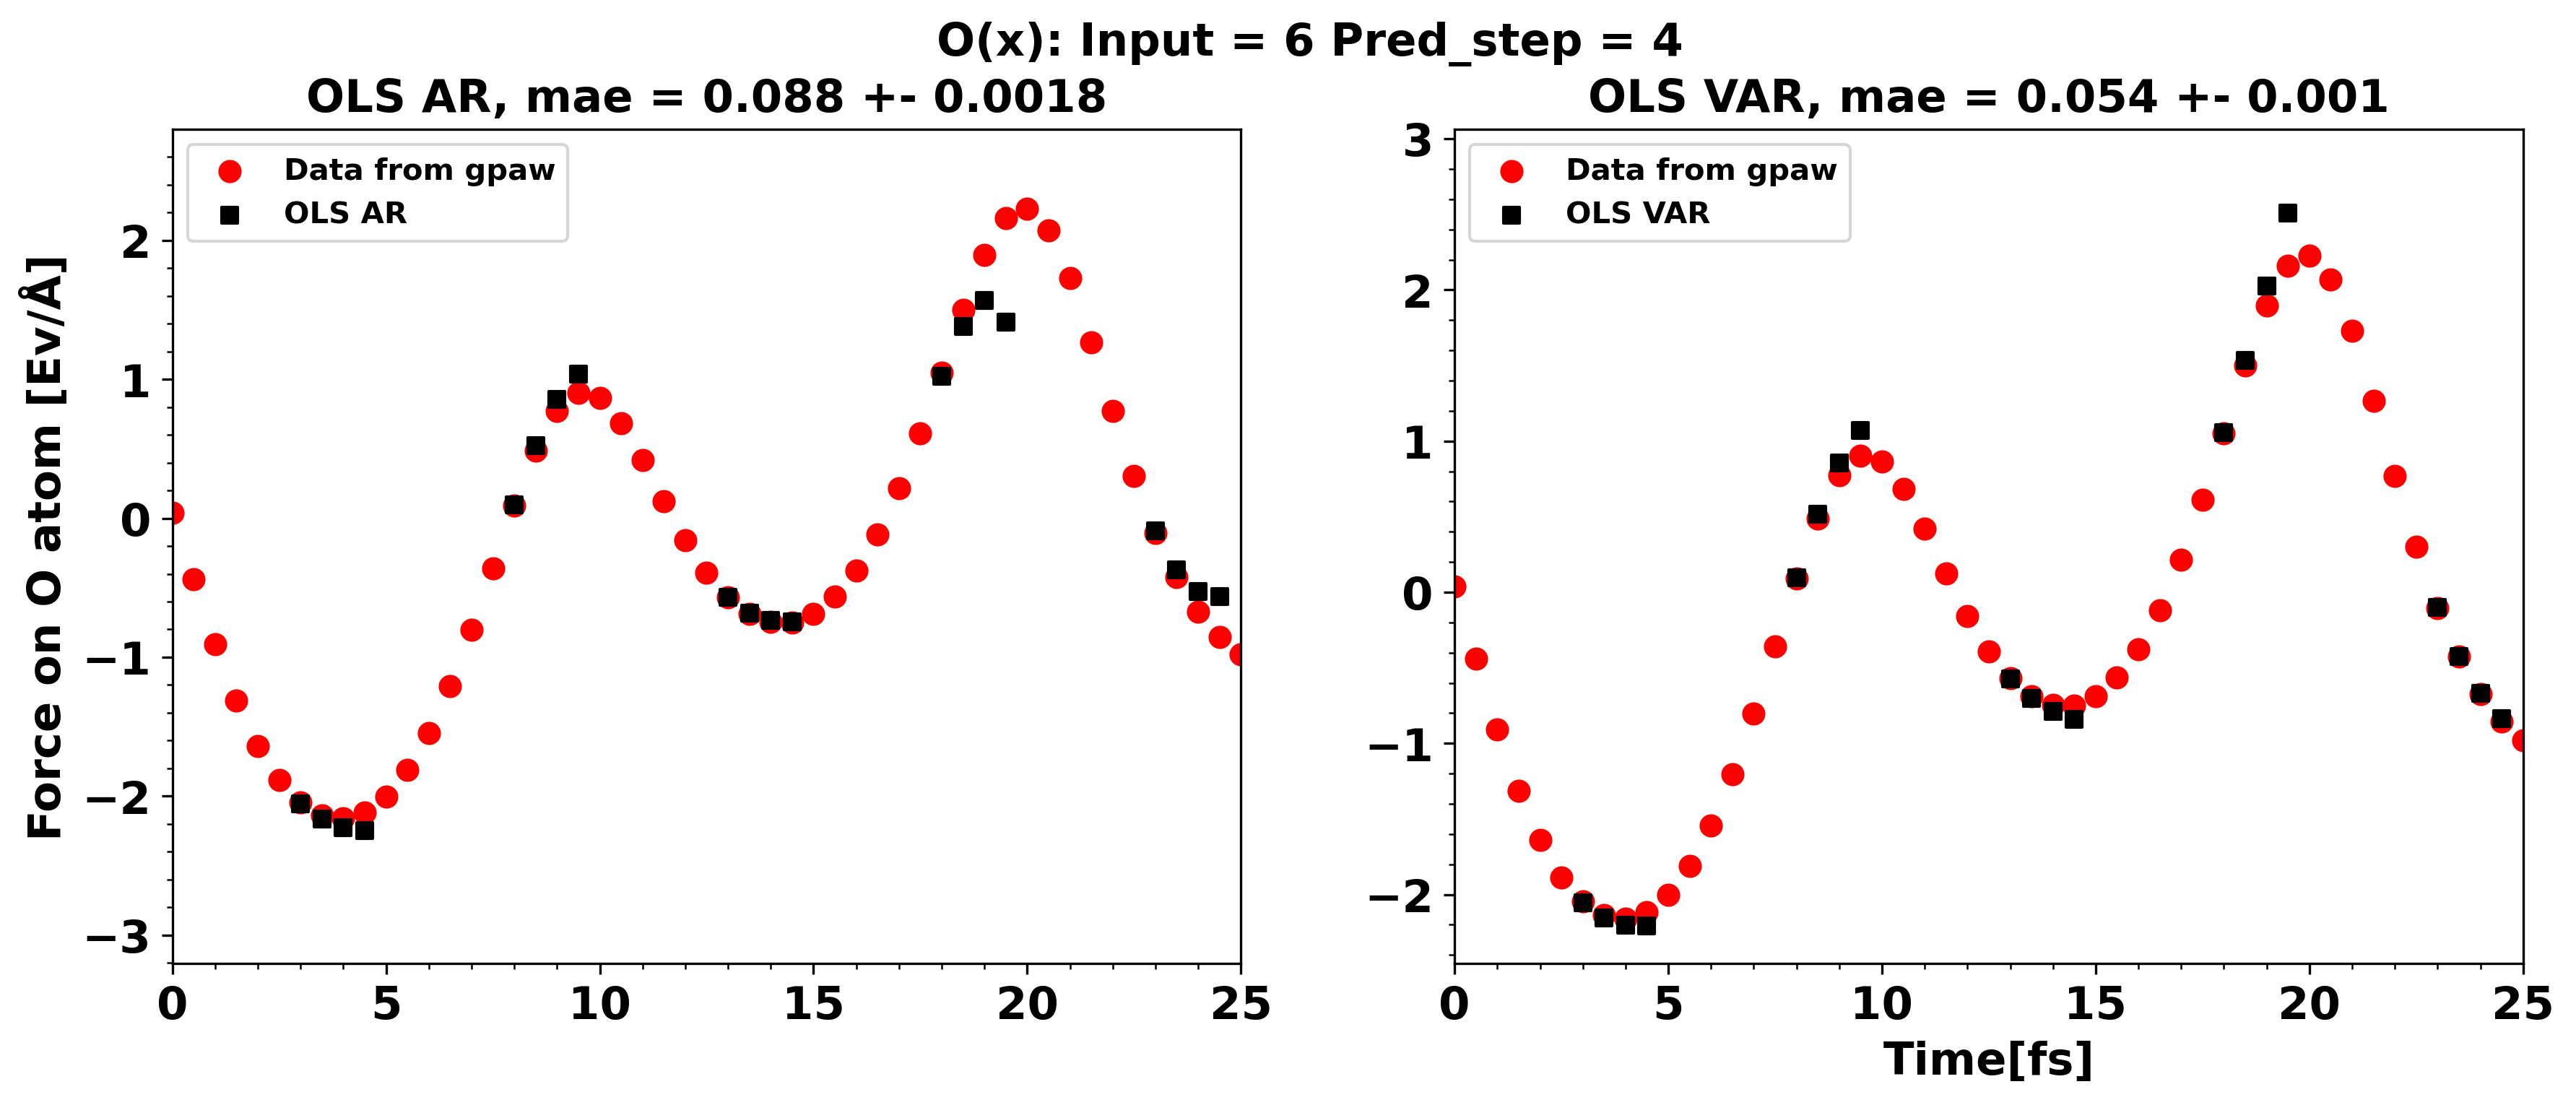

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
force_O = np.array([force_df['O(x)'], force_df['O(y)'], force_df['O(z)']])

ax[0].scatter(force_df['Unnamed: 0']*0.5, force_O[0,:], color="red", label="Data from gpaw", s=45)
ax[0].scatter(time*0.5, OLS_AR, label="OLS AR", s=30, marker="s", color="Black")
ax[0].legend()
ax[1].scatter(force_df['Unnamed: 0']*0.5, force_O[0,:], color="red", label="Data from gpaw", s=45)
ax[1].scatter(time*0.5, OLS_VAR, label="OLS VAR", s=30, marker="s", color="Black")
ax[1].legend()
ax[0].set_title("OLS AR, mae = "+str(np.round(mae_ridge, 3))+" +- "+str(np.round(std_ridge, 4)), fontweight="bold")
ax[1].set_title("OLS VAR, mae = "+str(np.round(mae_x, 3))+" +- "+str(np.round(std_x, 4)), fontweight="bold")
ax[1].set_xlabel("Time[fs]", fontweight="bold")
ax[0].set_ylabel("Force on O atom [Ev/Å]", fontweight="bold")  
ax[0].set_xlim(0, 25)
ax[1].set_xlim(0, 25)
plt.suptitle("O(x): Input = "+str(input)+" Pred_step = "+str(pred_step), fontweight="bold", fontsize=15)
OLS_AR = pred_ridge[:len(time)]
plt.show()